In [3]:
import cv2
import numpy as np
import pandas as pd
from funcs import *
import scipy.stats as st

In [4]:
# load the eye mask and create a dense contour
catalog_num = input("Enter the Catalog Number: \n")
which_eye = input("Which eye? 'left' or 'right': \n")
mask_path = 'data/' + catalog_num + '/' + "eye_mask_" + which_eye + ".jpg"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [5]:
# calculate the pixel size of the headfrontal image
img_path = 'data/' + catalog_num + '/' + get_image_names('data/' + catalog_num, 'hef')
pixel_size = get_pixel_size_mm_test(img_path, color='b')

# load the ommatidia diameter 
bee_df = pd.read_csv('results/apidae.csv')
omma_diameter = bee_df.loc[bee_df['catalogNumber'] == catalog_num, 'sample_diameter_mm'].iloc[0]
print(catalog_num)
print("Ommatidia diameter in mm: ", omma_diameter)
print("omma_diameter in pixels: ", omma_diameter / pixel_size)

The scale bar length is 1 mm
Width of the rectangle in pixels: 855
The pixel size is 0.00117
UCSB-IZC00035539
Ommatidia diameter in mm:  0.0238
omma_diameter in pixels:  20.341880341880344


## Visualize the Contours 

The angle of contour segment: 134.7903750859446


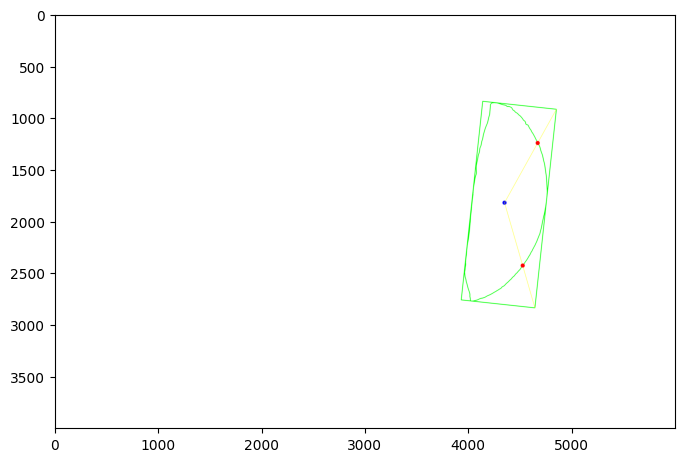

In [6]:
cnt = max(contours, key=cv2.contourArea)
canvas = np.zeros_like(mask)
canvas.fill(255)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)

# find the bounding box of the contour 
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
angle1 = rect[2]


if angle1 > 45 and which_eye == "left":
    # rotate the eye to make the following code works
    cnt = rotate_contour(cnt, 90-angle1)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

if angle1 > 45 and which_eye == "right":
    # rotate the eye to make the following code works
    cnt = rotate_contour(cnt, 90-angle1)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

cv2.drawContours(canvas,[box],0,(0,255,),5)
cv2.drawContours(canvas, cnt, -1, (0, 255, 0), 5)

# find the centroid of the shape
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
centroid_point = (cx,cy)
cv2.circle(canvas, (cx, cy), radius=20, color=(0, 0, 255), thickness=-1)


if which_eye == "left":
    sorted_indices = np.argsort(-box[:, 0])
    right_two_indexes = sorted_indices[:2]
    right_two_points = box[right_two_indexes]
    right1 = right_two_points[0]
    right2 = right_two_points[1]

    point1, index1= find_closest_point(centroid_point, tuple(right1), cnt)
    point2, index2 = find_closest_point(centroid_point, tuple(right2), cnt)
    cv2.line(canvas, centroid_point, tuple(right1), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.line(canvas, centroid_point, tuple(right2), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(canvas, tuple(point1), 20, (255, 0, 0), -1)
    cv2.circle(canvas, tuple(point2), 20, (255, 0, 0), -1)
    print("The angle of contour segment:", angle_between_3_points(right1, centroid_point, right2))

if which_eye == "right":

    sorted_indices = np.argsort(box[:, 0])
    left_two_indexes = sorted_indices[:2]
    left_two_points = box[left_two_indexes]
    left1 = left_two_points[0]
    left2 = left_two_points[1]

    point1, index1= find_closest_point(centroid_point, tuple(left1), cnt)
    point2, index2 = find_closest_point(centroid_point, tuple(left2), cnt)
    cv2.line(canvas, centroid_point, tuple(left1), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.line(canvas, centroid_point, tuple(left2), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(canvas, tuple(point1), 20, (255, 0, 0), -1)
    cv2.circle(canvas, tuple(point2), 20, (255, 0, 0), -1)
    print("The angle of contour segment:", angle_between_3_points(left1, centroid_point, left2))


plt.figure(figsize=(8,8))
plt.imshow(canvas)
plt.axis('on')
plt.show()

In [7]:
# segment the contour 
index = np.sort([index1, index2])
segments = np.split(cnt, index)[1]
rotatable_segments = rotate_contour(segments, 90)

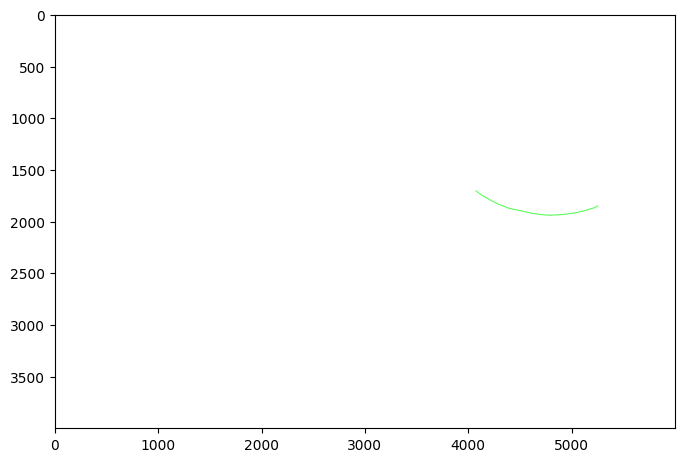

In [8]:
canvas = np.zeros_like(mask)
canvas.fill(255)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canvas, rotatable_segments, -1, (0, 255, 0), 5)

plt.figure(figsize=(8,8))
plt.imshow(canvas)
plt.axis('on')
plt.show()

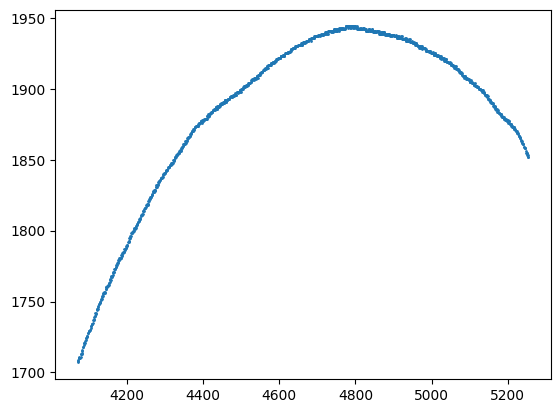

In [9]:
# project contours into R^2 
from scipy.spatial import distance

coords = rotatable_segments.reshape((len(rotatable_segments), 2))
#coords = sorted(coords, key=lambda coord: coord[0])
sorted_indices = np.argsort(coords[:, 0])
coords = coords[sorted_indices]

x_values = [coord[0] for coord in coords]
y_values = [coord[1] for coord in coords]

plt.scatter(x_values, y_values, s=1)
plt.show()

In [1135]:
# distance between adjacent points in the dense contour
distances = [distance.euclidean(coords[i], coords[i+1]) for i in range(len(coords)-1)]
print(list(set(distances)))
coords.shape

[0.0, 1.4142135623730951, 2.23606797749979, 2.0, 2.8284271247461903, 1.0]


(1094, 2)

There are only two different distances between adjacent points in the dense contour

## Points Sampling on the contour Example

In [10]:
import random
# sample size 
num_points = 8
# distance between adjacent points in the dense contour
adj_point_dist = 35
# make sure no out of range
upper_bound = int(np.ceil(adj_point_dist*num_points))
new_coords = coords[:-abs(upper_bound)]
start = random.choice(new_coords)

The coordinates of sampled ommatidia are:
[[4341.664379069531, 1856.0], [4375.0, 1870.4417465930578], [4409.649991458085, 1879.0], [4441.266346849768, 1887.7336531502322], [4477.0, 1894.7163089161127], [4510.670386834523, 1901.3296131654772], [4544.909290556191, 1909.8185811123826]]


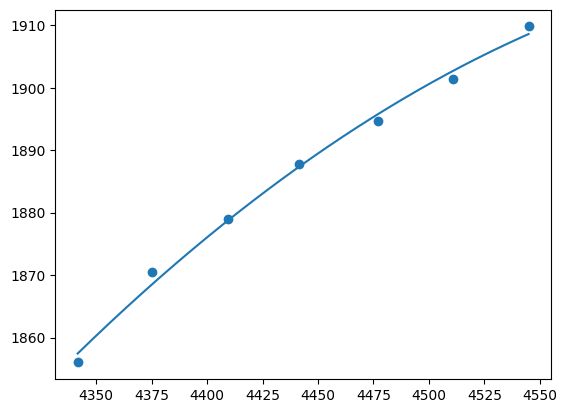

In [12]:
import random
# sample size 
num_points = 7
# distance between adjacent points in the dense contour
adj_point_dist = 45
# make sure no out of range
upper_bound = int(np.ceil(adj_point_dist*num_points))
new_coords = coords[:-abs(upper_bound)]
start = random.choice(new_coords)

# problem with updating current_index
omma_points = []
current_omma = start
new_coords_omma = coords.copy()
current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

i = 0 
while i < num_points:
    i += 1
    current_index, next_omma = find_point_on_line(new_coords_omma, adj_point_dist, current_omma, current_index)
    new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
    omma_points.append(next_omma)
    current_omma = next_omma

# coordninates of sampled ommatidia
print("The coordinates of sampled ommatidia are:")
print(omma_points)

# fit the sampled points to a polynomial regression
from scipy.optimize import curve_fit

x = np.array([p[0] for p in omma_points])
y = np.array([p[1] for p in omma_points])

coeffs = np.polyfit(x, y, 2)
curve = np.poly1d(coeffs)

# plot the closed curve 
xp = np.linspace(x[0], x[-1], 1000)
plt.plot(xp, curve(xp))
plt.scatter(x,y)
plt.show()

## Sampling Interommatidial Angles

On the polynomial curve we defined, we sample two points whose distance on curve equals to the ommatidia diameter in pixel size. Our algorithm is able to achieve accuracy after 2 decimal points with satisfying computing efficiency.

In [1120]:
import time

start_time = time.time()

dp_dx = curve.deriv()
def integrand_test(x):
    return np.sqrt(1 + dp_dx(x)**2)

x_omma1 = np.random.uniform(xp[0],xp[-1])
y_omma1 = curve(x_omma1)

arc_length = omma_diameter/pixel_size
x_omma2 = find_x2(arc_length, x_omma1, integrand_test)
arc_length, _ = quad(integrand_test, x_omma1, x_omma2)

end_time = time.time()
running_time = end_time - start_time
print("Running time:", running_time, "seconds")
print(arc_length)

Running time: 0.01318216323852539 seconds
18.158179393584767


In [13]:
from tqdm import tqdm
angle_list = []

for i in tqdm(range(100)):
    # change number of omma and omma diameter here to sample
    # good polynomial regression
    num_points = 5
    adj_point_dist = 50
    upper_bound = int(np.ceil(adj_point_dist*num_points))
    new_coords = coords[:-abs(upper_bound)]
    start = random.choice(new_coords)

    omma_points = []
    current_omma = start
    new_coords_omma = coords.copy()
    current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

    i = 0 
    while i < num_points:
        i += 1
        current_index, next_omma = find_point_on_line(new_coords_omma, adj_point_dist, current_omma, current_index)
        new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
        omma_points.append(next_omma)
        current_omma = next_omma
    
    x = np.array([p[0] for p in omma_points])
    xp = np.linspace(x[0], x[-1], 1000)
    y = np.array([p[1] for p in omma_points])

    coeffs = np.polyfit(x, y, 2)
    y_fit = np.polyval(coeffs, x)
    sse = np.sum((y_fit - y)**2)

    if sse > 2.5:
        continue 
    else:
        poly_curve = np.poly1d(coeffs)
        deriv1 = poly_curve.deriv()

        def integrand(x):
            return np.sqrt(1 + deriv1(x)**2) 
        
        for i in range(50):
            x_omma1 = np.random.uniform(xp[0],xp[-1])
            y_omma1 = poly_curve(x_omma1)
    
            arc_length = omma_diameter/pixel_size
            x_omma2 = find_x2(arc_length, x_omma1, integrand)
            
            if x_omma2 > xp[-1]:
                continue
                
            y_omma2 = poly_curve(x_omma2)
            d1 = deriv1(x_omma1)
            d2 = deriv1(x_omma2)
            m1 = -1/d1
            b1 = y_omma1 - m1 * x_omma1
            m2 = -1/d2
            b2 = y_omma2 - m2 * x_omma2
            x_intersect = (b2 - b1) / (m1 - m2)
            y_intersect = m1 * x_intersect + b1

            angle = np.arctan(abs((m2 - m1) / (1 + m1 * m2)))
            angle_list.append(angle)       

100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


In [1155]:
import numpy as np
import scipy.stats as st

min_angle = 0.005
max_angle = 0.04
angle_list = [angle for angle in angle_list if angle >= min_angle and angle <= max_angle]


In [1156]:
len(angle_list)

2419

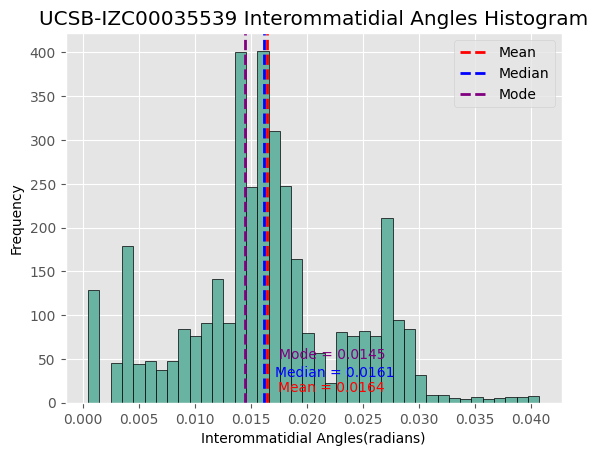

In [17]:
from statistics import mode

plt.hist(angle_list, edgecolor='black', color='#69b3a2', bins = 40)
plt.style.use('ggplot')
plot_mean = np.mean(angle_list)
plot_median = np.median(angle_list)
plot_mode = mode(round(num, 4) for num in angle_list)

plt.axvline(plot_mean, color='red', linestyle='--', linewidth=2)
plt.axvline(plot_median, color='blue', linestyle='--', linewidth=2)
plt.axvline(plot_mode, color='purple', linestyle='--', linewidth=2)

plt.text(x=plot_mean+0.001, y=12, s=f'Mean = {plot_mean:.4f}', fontdict=dict(color='red', size=10))
plt.text(x=plot_mode+0.003, y=50, s=f'Mode = {plot_mode:.4f}', fontdict=dict(color='purple', size=10))
plt.text(x=plot_median+0.001, y=30, s=f'Median = {plot_median:.4f}', fontdict=dict(color='blue', size=10))

plt.legend(['Mean','Median','Mode'])
plt.xlabel('Interommatidial Angles(radians)')
plt.ylabel('Frequency')
plt.title(catalog_num + ' Interommatidial Angles Histogram')

plt.show()

In [1125]:
interval = st.norm.interval(confidence=0.95, loc=np.mean(angle_list), scale=st.sem(angle_list))
print("The 95% confidence interval of radius of curvature is:", interval)


The 95% confidence interval of radius of curvature is: (0.01735937325153475, 0.018106506435437167)


## Calculate the visual acuity and Save it

cycle per degree (cpd) is calculated by 

In [1158]:
# randian to degree
cpd_mode = 1 / (2 * plot_mode * 180 / np.pi)
cpd_mean = 1 / (2 * plot_mean * 180 / np.pi)
cpd_median = 1 / (2 * np.rad2deg(plot_median))
#cpd_interval = 1 / (2 * np.rad2deg(interval))

In [1159]:
print(cpd_mode)
print(cpd_mean)
print(cpd_median)
#print(cpd_interval)

0.6018376731014928
0.43141939177037475
0.45298365527717455


If you are statisfied with the result, save the result

In [1160]:
# Find the row index for the catalog_num
row_index = bee_df.index[bee_df['catalogNumber'] == catalog_num].tolist()

if len(row_index) == 1:
    # Update the row with the cpd statistics
    bee_df.loc[row_index[0], 'cpd_mean'] = round(cpd_mean, 6)
    bee_df.loc[row_index[0], 'cpd_mode'] = round(cpd_mode, 6)
    bee_df.loc[row_index[0], 'cpd_median'] = round(cpd_median, 6)
    #bee_df.loc[row_index[0], 'cpd_interval'] = cpd_interval

    # Save the updated DataFrame to a CSV file
    bee_df.to_csv('results/apidae.csv', index=False)
else:
    print(f"Error: catalogNumber {catalog_num} not found or not unique")